In [1]:
import sys
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
sys.path.append("..")
from mango.environments import frozen_lake
import utils
import torch
torch.set_default_device('cuda:0' if torch.cuda.is_available() else 'cpu')

Observation:
 (torch.Size([3, 6, 6]), torch.float32, device(type='cuda', index=0))


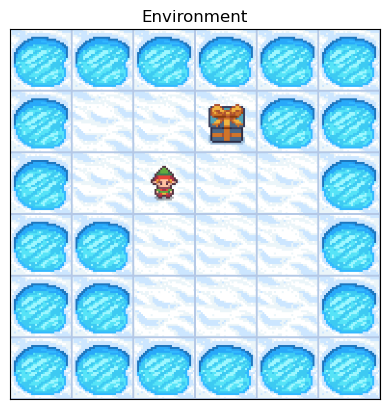

In [2]:
params = dict(map_name="RANDOM", p=None, shape=(4,4), seed=42)
env = frozen_lake.CustomFrozenLakeEnv(**params)
env = frozen_lake.wrappers.ReInitOnReset(env, **params)
env = frozen_lake.wrappers.TensorObservation(env, one_hot=True)
obs, info = env.reset()
print(f"Observation:\n {obs.shape, obs.dtype, obs.device}")
utils.render(env)

In [3]:
from mango.mango import MangoEnv, Agent
from mango.policies.experiencereplay import ExperienceReplay
from mango.policies.dqnet import DQNetTrainer, DQNetPolicy
from mango.neuralnetworks.networks import ConvEncoder

net_kwargs = dict(hidden_channels=[8, 8, 8], hidden_features=[])
trainer_kwargs = dict(lr=1e-3, gamma=0.99, tau=1e-3)


net = ConvEncoder(in_channels=None, out_features=int(env.action_space.n), **net_kwargs).eval()
policy = DQNetPolicy(net, env.action_space)
trainer = DQNetTrainer(net, **trainer_kwargs)
replay = ExperienceReplay()
agent = Agent(MangoEnv(env), policy)

In [4]:
import snakeviz
%load_ext snakeviz

In [5]:
#%%snakeviz -t
train_loss_log = []
test_loss_log = []
train_reward_log = []
test_reward_log = []

for episode in tqdm(range(1000)):
    trans = agent.run_episode(randomness=0.5)
    replay.extend(trans.steps)

    if replay.can_sample():
        info = trainer.train(replay.sample())
        replay.update_priorities_last_sampled(info.td)
        train_loss_log.append(info.loss)
    train_reward_log.append(trans.reward)

    
    if episode % 10 == 0:
        trans = agent.run_episode(randomness=0.0)
        

  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 100: 0.058924559503793716
Episode 200: 0.036417774856090546
Episode 300: 0.026146767660975456
Episode 400: 0.031227631494402885
Episode 500: 0.03252870589494705
Episode 600: 0.041800640523433685
Episode 700: 0.062385302037000656
Episode 800: 0.023739298805594444
Episode 900: 0.052254632115364075


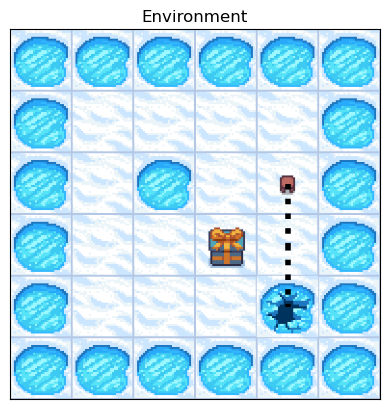

In [12]:
trans = agent.run_episode(randomness=0.0)
utils.render(env, trajectory=trans.trajectory)